In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, metrics
from tqdm import tqdm_notebook as tqdm
import random
from sklearn.dummy import DummyClassifier
from scipy import stats
import math
from skimage import morphology, img_as_bool
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# path_to_data = "gdrive/My Drive/data/train_images.npy"
# path_to_labels = "gdrive/My Drive/data/train_labels.csv"
# path_to_test = "gdrive/My Drive/data/test_images.npy"

path_broad = "gdrive/My Drive/Mcgill/U4/Fall 2018/COMP 551/kaggle/data/"
path_to_data = path_broad + "train_images.npy"
path_to_labels = path_broad + "train_labels.csv"
path_to_test = path_broad + "test_images.npy"

In [0]:
def plot_images(list_of_images, max_col = 4):
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0], cmap="gray"); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(20, max_col * r))
        for i, (img,name) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title(str(name))
            ax.axis('off')
            ax.imshow(img, cmap="gray")

In [0]:
def get_data(path_x, path_y):
    data = np.load(path_x, encoding = 'bytes')
    labels_df = pd.read_csv(path_y)
    labels_df.Category = pd.Categorical(labels_df.Category)
    y = labels_df.Category.cat.codes.values
    X = np.array(data[:, 1])
    for c, i in enumerate(X):
        ret,thresh_img = cv2.threshold(i,127,255,cv2.THRESH_BINARY)
        X[c] = thresh_img
    return X, y

In [7]:
X_noisy, y = get_data(path_to_data, path_to_labels)
print("Shape of training dataset:", len(X_noisy))
X_test = list(np.load(path_to_test, encoding = 'bytes')[:, 1])
print("Shape of testing dataset:", len(X_test))
unique_classes = set(y)
print("Number of classes:", len(unique_classes))

Shape of training dataset: 10000
Shape of testing dataset: 10000
Number of classes: 31


In [0]:
from scipy import ndimage

def remove_noise(filledImg, min_size = 500):
    blobs, min_val = ndimage.label(filledImg)
    
    for i in range(10,60):
        clean_img = morphology.remove_small_objects(img_as_bool(filledImg), i)
        blobs, number_of_blobs = ndimage.label(clean_img)
        if number_of_blobs < min_val:
            min_val = number_of_blobs
            if min_val == 1:
                return clean_img
  
    return clean_img

In [9]:
X = []
for c, (img, label) in enumerate(zip(X_noisy, y)):
    img = img.reshape(100, 100)
    X.append(remove_noise(img, 100).flatten())  

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
for c, img in enumerate(X):
    X[c] = np.array(img)
X = np.array(X)

In [0]:
def crop_image(array_X, size_of_image = 100, size_of_crop = 32, show_image = False):
  cropped = []
  cropBox = None
  for i in range(len(array_X)):
    test = array_X[i]
    test.resize(size_of_image,size_of_image)
    image_data = test
    if cropBox == None:
      prev_cropBox = None
    else:
      prev_cropBox = cropBox[:]

    try:  
      non_empty_columns = np.where(image_data.max(axis=0)>0)[0]
      non_empty_rows = np.where(image_data.max(axis=1)>0)[0]
      cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    except:
      cropBox = prev_cropBox
    shiftX = size_of_crop
    shiftY = size_of_crop
    cropBox = list(cropBox)
    if(cropBox[0] >= 5):
      cropBox[0] -= 5

    if(cropBox[0]+shiftX >= size_of_image):
      cropBox[0] = size_of_image - shiftX - 1

    if(cropBox[2] >= 5):
      cropBox[2] -= 5

    if(cropBox[2]+shiftY >= size_of_image):
      cropBox[2] = size_of_image - shiftY - 1

    image_data_new = image_data[cropBox[0]:cropBox[0]+shiftX, cropBox[2]:cropBox[2]+shiftY]
    
    if show_image:
      plot_images(np.array([image_data_new]))

    cropped.append(image_data_new.flatten())
  
  for c, img in enumerate(cropped):
    cropped[c] = np.array(img)
  cropped = np.array(cropped)
  return cropped

In [0]:
X_cropped = crop_image(X, size_of_crop=32)

In [15]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64
num_classes = 31
epochs = 35

# input image dimensions
img_rows, img_cols = 32, 32
# the data, split between train and val sets
(x_train, y_train), (x_val, y_val) = (X_cropped[:9488],y[:9488]), (X_cropped[9488:],y[9488:]) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train[3])
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

datagen.fit(x_train)
val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

# Set our optimizer and loss function (similar settings to our CAE approach)
model.compile(loss = keras.losses.categorical_crossentropy,
            optimizer = optimizer,
            metrics = ['categorical_accuracy'])


callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                      factor=0.1, patience=5,
                      min_delta=0.0001, mode='auto',
                      cooldown=0, verbose=1, 
                      min_lr=0)
]

model.fit_generator(train_generator,
          steps_per_epoch= 14000 // batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(x_val, y_val),
          callbacks = callbacks
          )


score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (9488, 32, 32, 1)
9488 train samples
512 val samples
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/85
218/218 [==============================] - 11s 52ms/step - loss: 2.7486 - categorical_accuracy: 0.2144 - val_loss: 1.9055 - val_categorical_accuracy: 0.4277
Epoch 2/85
218/218 [==============================] - 7s 33ms/step - loss: 2.2419 - categorical_accuracy: 0.3498 - val_loss: 1.6782 - val_categorical_accuracy: 0.5078
Epoch 3/85
218/218 [==============================] - 8s 35ms/step - loss: 2.0182 - categorical_accuracy: 0.4197 - val_loss: 1.4887 - val_categorical_accuracy: 0.5645
Epoch 4/85
218/218 [==============================] - 8s 35ms/step - loss: 1.8654 - categorical_accuracy: 0.4605 - val_loss: 1.3380 - val_categorical_accuracy: 0.6152
Epoch 5/85
218/218 [==============================] - 7s 34ms/step - loss: 1.7688 - categorical_accuracy: 0.4907 - val_loss: 1.2972 - val_categorical_accuracy: 0.6367


In [16]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)
  
  
batch_size = 64
num_classes = 31
epochs = 100

# input image dimensions
img_rows, img_cols = 32, 32
# the data, split between train and val sets
(x_train, y_train), (x_val, y_val) = (X_cropped[:9488],y[:9488]), (X_cropped[9488:],y[9488:]) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train[3])
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

datagen.fit(x_train)
val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

model_mn = MobileNet(input_shape=(img_rows, img_cols, 1), alpha=1., weights=None, classes=num_classes)
model_mn.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])



callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]

hist = model_mn.fit_generator(
    train_generator, steps_per_epoch= 14000 // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks
)

score = model_mn.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (9488, 32, 32, 1)
9488 train samples
512 val samples
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/100
218/218 [==============================] - 19s 89ms/step - loss: 3.0663 - categorical_crossentropy: 3.0663 - categorical_accuracy: 0.1593 - top_3_accuracy: 0.3572 - val_loss: 3.4743 - val_categorical_crossentropy: 3.4743 - val_categorical_accuracy: 0.0566 - val_top_3_accuracy: 0.1230
Epoch 2/100
218/218 [==============================] - 14s 62ms/step - loss: 2.6984 - categorical_crossentropy: 2.6984 - categorical_accuracy: 0.2413 - top_3_accuracy: 0.4965 - val_loss: 3.5479 - val_categorical_crossentropy: 3.5479 - val_categorical_accuracy: 0.0566 - val_top_3_accuracy: 0.1328
Epoch 3/100
218/218 [==============================] - 14s 62ms/step - loss: 2.5586 - categorical_crossentropy: 2.5586 - categorical_accuracy: 0.2876 - top_3_accuracy: 0.5452 - val_loss: 2.9849 - val_categorical_crossentropy: 2.9849 - val_cat

In [0]:
model_cnn = model

In [21]:
test = []
for c, img in enumerate(X_test):
    img = img.reshape(100, 100)
    test.append(remove_noise(img, 100).flatten())
    
for c, img in enumerate(test):
    test[c] = np.array(img)
test = np.array(test)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
test_cropped = crop_image(test)

In [0]:
test_x = test_cropped
if K.image_data_format() == 'channels_first':
    test_x = test_x.reshape(test_x.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
test_x = test_x.astype('float32')

In [27]:
prediction_cnn = model_cnn.predict_classes(test_x, batch_size=1, verbose=1)

10000/10000 [==============================] - 21s 2ms/step


In [35]:
print((prediction_cnn))

[16 14 26 ... 27 16  9]


In [56]:
prediction_mn = model_mn.predict(test_x, batch_size=1, verbose=1)

10000/10000 [==============================] - 59s 6ms/step


In [33]:
print(type(prediction_mn))

<class 'numpy.ndarray'>


In [36]:
prediction_mn = np.argmax(prediction_mn,axis=1)
print(prediction_mn)

[16 14 26 ... 21 16  9]


In [0]:
temp = prediction_mn - prediction_cnn

In [55]:
prediction_cnn = model_cnn.predict(test_x, batch_size=1, verbose=1)

10000/10000 [==============================] - 21s 2ms/step


In [0]:
sum_ = prediction_cnn + prediction_mn
sum_ = np.argmax(sum_,axis=1)

In [0]:
result_sum = []
for index, image in enumerate(sum_):
  result_sum.append(cat_map[image])
  
result_sum = pd.DataFrame(result_sum)
result_sum = result_sum.reset_index(drop=False)
result_sum.columns=['Id', 'Category']
result_sum.to_csv('result_sum.csv', index=False)

In [0]:
import pandas as pd
result_cnn, result_mn = [], []
labels_df = pd.read_csv(path_to_labels)
labels_df.Category = pd.Categorical(labels_df.Category)
cat_map = pd.Categorical(labels_df.Category)
cat_map = cat_map.categories

for index, image in enumerate(prediction_cnn):
  result_cnn.append(cat_map[image])

result_cnn = pd.DataFrame(result_cnn)
result_cnn = result_cnn.reset_index(drop=False)
result_cnn.columns=['Id', 'Category']
result_cnn.to_csv('result_cnn.csv', index=False)



for index, image in enumerate(prediction_mn):
  result_mn.append(cat_map[image])
  
result_mn = pd.DataFrame(result_mn)
result_mn = result_mn.reset_index(drop=False)
result_mn.columns=['Id', 'Category']
result_mn.to_csv('result_mn.csv', index=False)

In [50]:
print(type(result_cnn))

<class 'pandas.core.frame.DataFrame'>


In [68]:
print(result_sum)

        Id      Category
0        0     pineapple
1        1       penguin
2        2          sink
3        3         empty
4        4         empty
5        5         empty
6        6      scorpion
7        7      scorpion
8        8     pineapple
9        9      scorpion
10      10        pencil
11      11     pineapple
12      12          sink
13      13         skull
14      14         panda
15      15        pencil
16      16         rifle
17      17     pineapple
18      18  rollerskates
19      19         rifle
20      20      sailboat
21      21          pool
22      22          nail
23      23      scorpion
24      24         panda
25      25         mouth
26      26      scorpion
27      27      scorpion
28      28        rabbit
29      29        shovel
...    ...           ...
9970  9970    skateboard
9971  9971        parrot
9972  9972      squiggle
9973  9973          pool
9974  9974         mouth
9975  9975      scorpion
9976  9976        rabbit
9977  9977         panda


In [85]:
count = 0 
for c, (a, b) in enumerate(zip(result_cnn.values, result_mn.values)):
  s = result_sum.values[c][1]
  if a[1] != s and b[1] != s:
#     print(s)
#     print (c, a[1], b[1])
    count +=1 
print(count)


188


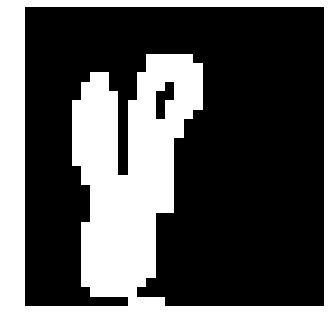

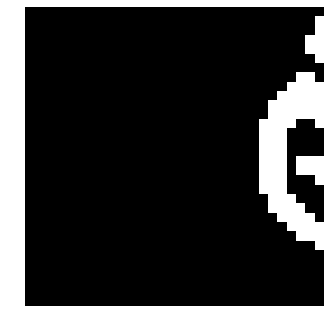

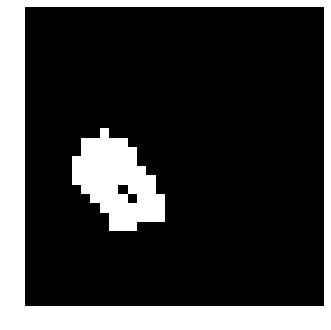

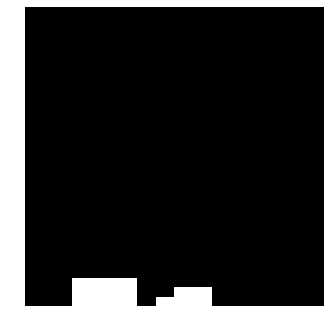

In [82]:
plot_images([test_x[1476].reshape(32,32)])
plot_images([test_x[1526].reshape(32,32)])
plot_images([test_x[1589].reshape(32,32)])
plot_images([test_x[1644].reshape(32,32)])